In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
import geopandas as geop
import xgboost as xgb
import cartopy

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, LassoLarsIC, Lasso, BayesianRidge, Ridge, LassoLars, LassoLarsCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, ParameterSampler

warnings.filterwarnings('ignore')

In [2]:
# Archivo Zona Prop.
df = pd.read_csv('data/train.csv', error_bad_lines=False)
# Google Trends.
trends = pd.read_csv('data/sentiment_google.csv')
trends['fecha'] = trends.Month.astype(np.datetime64)

In [3]:
trends = pd.read_csv('data/sentiment_google.csv')
trends['fecha'] = trends.Month.astype(np.datetime64)

In [11]:
# Memory Usage
(df.memory_usage() / (1024 * 1024)).sum()

42.11433410644531

In [85]:
# Como castear campos bool a int 16
df = df.astype({"piscina": 'int16', "usosmultiples": 'int16', "escuelascercanas": 'int16', "centroscomercialescercanos": 'int16'})
# Cambio en memoria
(df.memory_usage() / (1024 * 1024)).sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 0 to 239999
Data columns (total 30 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

In [13]:
# Memory Usage
(df.memory_usage() / (1024 * 1024)).sum()

36.62117004394531

In [4]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
nulls

,nulls,porcentaje
id,0,0.00
escuelascercanas,0,0.00
piscina,0,0.00
usosmultiples,0,0.00
gimnasio,0,0.00
fecha,0,0.00
centroscomercialescercanos,0,0.00
precio,0,0.00
tipodepropiedad,46,0.02
provincia,155,0.06


In [5]:
df.get_dtype_counts()

float64    15
int64       1
object      7
dtype: int64

In [6]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('precio')
quantitative.remove('id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [7]:
quantitative

['antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos']

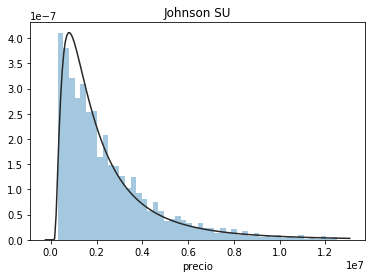

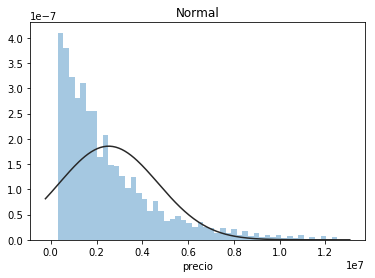

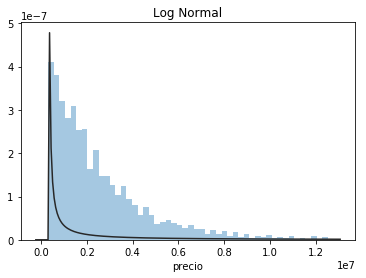

In [8]:
# Podemos observar que la distribucion de los precios no respeta una curva normal.

y = df['precio']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [9]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(df[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


In [10]:
feat = df.sample(50000)

In [23]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'precio']].groupby(feature).mean()['precio']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(feat, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['titulo_E', 'descripcion_E', 'tipodepropiedad_E', 'direccion_E', 'ciudad_E', 'provincia_E', 'fecha_E']


In [24]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['precio'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = quantitative + qual_encoded
#spearman(df, features)

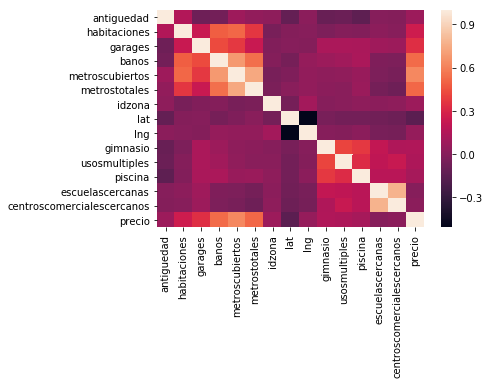

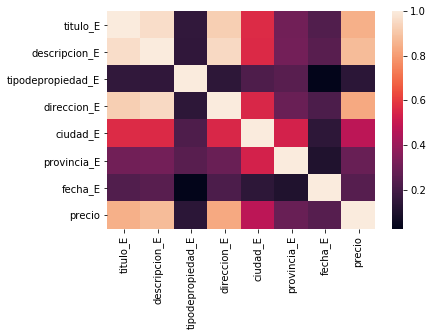

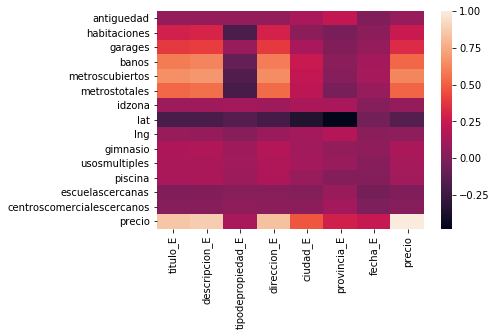

In [27]:
plt.figure(1)
corr = feat[quantitative+['precio']].corr()
sns.heatmap(corr)
plt.figure(2)
corr = feat[qual_encoded+['precio']].corr()
sns.heatmap(corr)
plt.figure(3)
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded)+1]), index=quantitative+['precio'], columns=qual_encoded+['precio'])
for q1 in quantitative+['precio']:
    for q2 in qual_encoded+['precio']:
        corr.loc[q1, q2] = feat[q1].corr(feat[q2])
sns.heatmap(corr)

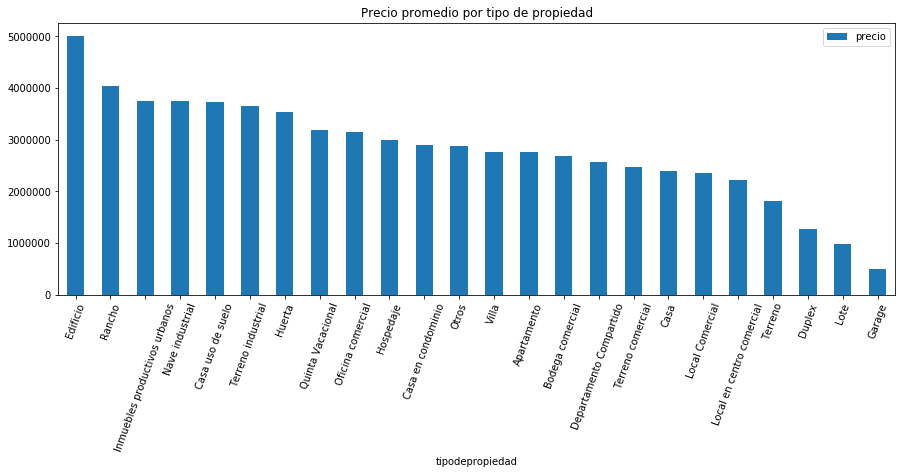

In [37]:
df.groupby('tipodepropiedad').agg({'precio': 'mean'})\
    .sort_values('precio', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por tipo de propiedad");

1.0


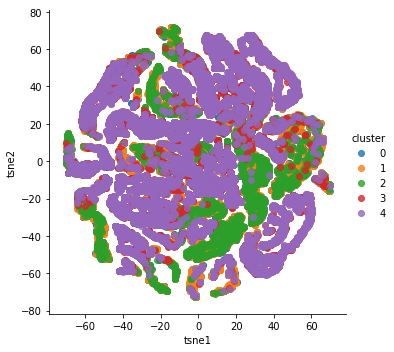

In [31]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = feat[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=21)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

In [17]:
print("Valores únicos piscina: ", df.piscina.unique())
print("Valores únicos usos multiples: ", df.usosmultiples.unique())
print("Valores únicos escuelas cercanas: ", df.escuelascercanas.unique())
print("Valores únicos centros comerciales cercanos: ", df.centroscomercialescercanos.unique())

Valores únicos piscina:  [0 1]
Valores únicos usos multiples:  [0 1]
Valores únicos escuelas cercanas:  [0 1]
Valores únicos centros comerciales cercanos:  [0 1]


In [18]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [19]:
df['fecha']= pd.to_datetime(df['fecha'], errors='coerce')
df['year']=df.fecha.dt.year

In [20]:
# Cargo la serie de inflación.
inflacion_mex = pd.read_csv('./data/inflacion_mex.csv',names=['fecha_mes','indice'],parse_dates=['fecha_mes'],dtype={'indice':np.float64})
# Cambio de base al ultimo dato.
infla2019 = inflacion_mex['indice'].tail(1).values[0]
inflacion_mex['indice'] = (inflacion_mex['indice']/infla2019)*100
# Elimino el número de día para poder joinear ambos DF.
inflacion_mex['fecha_mes'] = inflacion_mex['fecha_mes'].dt.to_period('M')
df['fecha_mes']= df['fecha'].dt.to_period('M')
df = df.merge(inflacion_mex,how='inner',on='fecha_mes')
df['precio_constantes'] = (df['precio']/df['indice'])*100

In [21]:
zp12= df.loc[df.year==2012]
zp13= df.loc[df.year==2013]
zp14= df.loc[df.year==2014]
zp15= df.loc[df.year==2015]
zp16= df.loc[df.year==2016]
zp17= df.loc[df.year==2017]

In [22]:
zp12s=zp12.sample(2000)

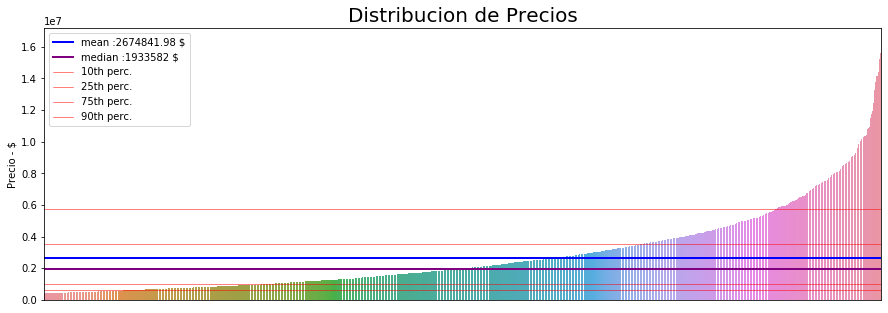

count       2000.00
mean     2674841.98
std      2335726.92
min       399805.00
25%      1018857.91
50%      1933581.95
75%      3547068.70
max     16375415.41
Name: precio_constantes, dtype: float64

In [23]:
fig, ax = plt.subplots(figsize=[15,5])

sns.barplot(x=zp12s['precio_constantes'],y=zp12s['precio_constantes'].sort_values())
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)

plt.axhline(zp12s['precio_constantes'].mean(),c = 'b', linewidth = 2, label = "mean :" + "%.2f"%zp12s['precio_constantes'].mean()+ " $")
plt.axhline(zp12s['precio_constantes'].median(),c = 'purple', linewidth = 2, label = "median :" + "%.0f"%zp12s['precio_constantes'].median()+ " $")

for i, quantile in enumerate([.1, 0.25, .75, .9]):
    ax.axhline(zp12s['precio_constantes'].quantile(quantile), label='%.0fth perc.' % (quantile*100), color = 'r', linewidth = 0.5)
    
plt.ylabel("Precio - $")
plt.legend()
plt.title('Distribucion de Precios',fontsize = 20)
plt.show()
zp12s['precio_constantes'].describe()

[(0, 5500000)]

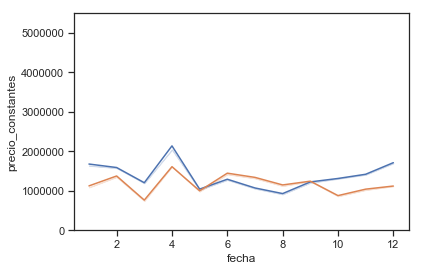

In [16]:
casash12 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2012)]
casash13 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2013)]
casash14 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2014)]
casash15 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2015)]
casash16 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2016)]
casash17 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==1)&(df.year==2017)]

#casash2 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==2)&(df.year==2012)]
#casash3 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==3)&(df.year==2012)]
#casash4 = df.loc[(df.tipodepropiedad=='Casa') & (df.habitaciones==4)&(df.year==2012)]
sns.set(style="darkgrid")
sns.set(style="ticks", color_codes=True)
#g = sns.lineplot(x=casash12.fecha.dt.month, y='precio_constantes', data=casash12, ci=1)
#g = sns.lineplot(x=casash13.fecha.dt.month, y='precio_constantes', data=casash13, ci=1)
#g = sns.lineplot(x=casash14.fecha.dt.month, y='precio_constantes', data=casash14, ci=1)
g = sns.lineplot(x=casash15.fecha.dt.month, y='precio_constantes', data=casash15, ci=1)
g = sns.lineplot(x=casash16.fecha.dt.month, y='precio_constantes', data=casash16, ci=1)
g = sns.lineplot(x=casash17.fecha.dt.month, y='precio_constantes', data=casash17, ci=1)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash2)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash3)
#g = sns.lineplot(x='fecha', y='precio_constantes', data=casash4)
g.set(ylim=(0, 5500000))

## Análisis de Títulos

In [128]:
tit_unicas = df['titulo'].value_counts().to_dict()

In [138]:
tit_df = pd.DataFrame(list(tit_unicas.items()), columns=['Content', 'xAppears'])

,Content,xAppears
0,casa en venta,468
1,departamento en venta,289
2,casa en venta en chihuahua,268
3,casa en venta en querétaro,238
4,departamento en venta en benito juárez,221
5,departamento en venta en miguel hidalgo,177
6,casa en venta en mérida,167
7,casa en venta,132
8,casa en venta en torreón,119
10,casa en venta en monterrey,115


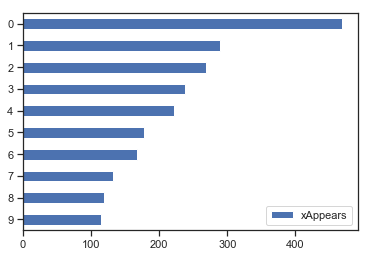

In [139]:
tit_df.sort_values(by='xAppears', ascending=True).tail(10).plot(kind='barh')
tit_df.sort_values(by='xAppears', ascending=False).head(10)

In [168]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 0 to 239999
Data columns (total 33 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipodepropiedad               239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
habitaciones                  217529 non-null float64
garages                       202235 non-null float64
banos                         213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
lat                           116512 non-null float64
lng                           116512 non-null float64
fecha                         240

In [208]:
def fun_bucket(i):

    if i.find('casa') > 0 and i.find('venta') > 0:
        return 'casa'
    elif i.find('departamento') > 0 and i.find('venta') > 0:
        return 'depto'
    elif i.find('WUACHIN'):
        return "WUACHIN"
    else:
        return 'otros'

dft = df
    
dft['bucket'] = dft['titulo'].fillna('WUACHIN').apply(fun_bucket)


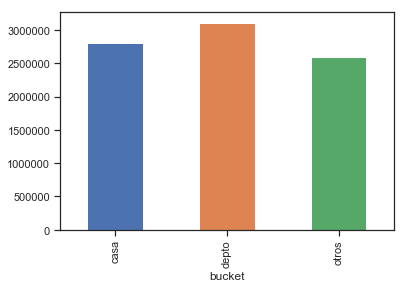

In [209]:
dft[dft.bucket != "WUACHIN"].groupby(dft.bucket)['precio'].mean().plot(kind='bar')
#dft['bucket'].value_counts()#.plot(kind='bar')

In [224]:
dft[dft.bucket != "WUACHIN"].groupby(['bucket'])['tipodepropiedad'].value_counts()

bucket  tipodepropiedad              
casa    Casa                             7954
        Casa en condominio                893
        Apartamento                        39
        Terreno                            28
        Casa uso de suelo                  25
        Duplex                             23
        Oficina comercial                   9
        Local Comercial                     5
        Quinta Vacacional                   5
        Bodega comercial                    4
        Edificio                            3
        Rancho                              2
        Villa                               2
        Departamento Compartido             1
        Inmuebles productivos urbanos       1
        Nave industrial                     1
        Otros                               1
depto   Apartamento                      3081
        Casa                               79
        Edificio                           16
        Departamento Compartido           

## Análisis de Descripciones 

In [127]:
desc_unicas = df['descripcion'].value_counts().to_dict()

In [18]:
desc_df = pd.DataFrame(list(desc_unicas.items()), columns=['Content', 'xAppears'])


,Content,xAppears
0,empresa dedicada a los ante notario y regist...,119
1,<br>,108
2,"casa, sala comedor, buenas condiciones.",77
3,"casa, sala comedor, patio de servicio, buenas ...",64
4,<br /><br />,59
5,empresa dedicada a los ante notario y regist...,51
6,valor comercial: \nprecio de venta: \n\n**un...,42
7,-- caia --,42
8,"<p>puedes pagarla de contado, infonavit, issst...",40
9,puedes recibir mayor información por whatsapp ...,33


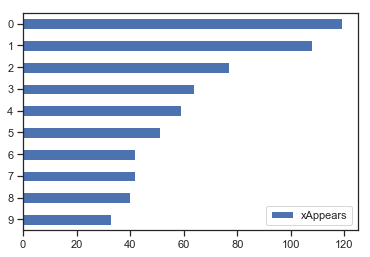

In [19]:
desc_df.sort_values(by='xAppears', ascending=True).tail(10).plot(kind='barh')
desc_df.sort_values(by='xAppears', ascending=False).head(10)

In [20]:
df = df.merge(desc_df,how='left',left_on='descripcion',right_on='Content')

In [21]:
def GetRealtor(x):
    if x > 1:
        return '1'
    else:
        return '0'

df['realtors']= df.xAppears.apply(GetRealtor)

In [51]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'year', 'fecha_mes', 'indice',
       'precio_constantes', 'Content', 'xAppears', 'realtors', 'precio_usd',
       'amenities', 'plus'],
      dtype='object')

realtors,0,1
year,,
2012,22945,589
2013,29408,978
2014,39391,1181
2015,49362,2108
2016,89437,4601


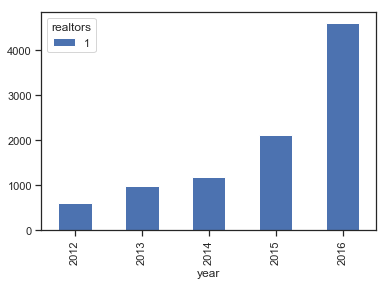

In [104]:
#df.groupby(['year','tipodepropiedad','habitaciones','banos'])['realtors'].value_counts().unstack()
df[(df['realtors'] == '1')].groupby(['year'])['realtors'].value_counts().unstack().plot(kind = 'bar')
df.groupby(['year'])['realtors'].value_counts().unstack()

In [82]:
df[df.tipodepropiedad.isin(['Apartamento','Casa','Casa en condominio','Terreno']) & (df.year == 2016)].\
groupby(['provincia','tipodepropiedad','year','realtors'])['precio'].mean().unstack()

realtors                                               0          1
provincia             tipodepropiedad    year                      
Aguascalientes        Apartamento        2016 2518333.33        nan
                      Casa               2016 1681422.00 1357543.33
                      Casa en condominio 2016 1997854.25        nan
                      Terreno            2016 1128288.86  398000.00
Baja California Norte Apartamento        2016  727695.10  591219.40
                      Casa               2016  778730.02 1012725.28
                      Casa en condominio 2016  809014.54  569500.00
                      Terreno            2016  559000.00        nan
Baja California Sur   Apartamento        2016 2002909.09 2335000.00
                      Casa               2016 1513813.67  738125.00
                      Casa en condominio 2016 5110000.00  703760.00
                      Terreno            2016 1020197.50 1443267.00
Campeche              Apartamento        2016 2183750.00        nan
                      Casa               2016 1898982.75 4120000.00
                      Casa en condominio 2016 1339500.00 4120000.00
                      Terreno            2016  751322.22        nan
Chiapas               Apartamento        2016  744166.67  522500.00
                      Casa               2016 2127979.81 1973786.68
                      Casa en condominio 2016 1698000.00        nan
                      Terreno            2016 1287800.82        nan
Chihuahua             Apartamento        2016 2744265.00  798500.00
                      Casa               2016 1871268.15 1398616.53
                      Casa en condominio 2016  851419.20  777313.50
                      Terreno            2016 1079257.77        nan
Coahuila              Apartamento        2016 1662500.00        nan
                      Casa               2016 1734715.89 1809445.25
                      Casa en condominio 2016 1244130.77 2846950.00
                      Terreno            2016 1258186.88        nan
Colima                Apartamento        2016 3075107.31  480000.00
                      Casa               2016 1810739.37  477773.50
...                                                  ...        ...
Sinaloa               Casa               2016 1666551.15 1095569.00
                      Casa en condominio 2016 1896410.55        nan
                      Terreno            2016 1236000.00        nan
Sonora                Apartamento        2016 1948298.30        nan
                      Casa               2016 1674869.33 2361301.15
                      Casa en condominio 2016  633392.50        nan
                      Terreno            2016  941964.71        nan
Tabasco               Apartamento        2016 2741070.47 2861500.00
                      Casa               2016 2766204.50 3690000.00
                      Casa en condominio 2016 4850000.00        nan
                      Terreno            2016 1257790.72        nan
Tamaulipas            Apartamento        2016  902437.94  403750.00
                      Casa               2016 1865414.34 1468004.18
                      Casa en condominio 2016 2094275.27 2390080.00
                      Terreno            2016  943456.86        nan
Tlaxcala              Apartamento        2016  457360.00        nan
                      Casa               2016 1104196.82 1641683.00
                      Casa en condominio 2016  685088.25        nan
                      Terreno            2016 2034938.46        nan
Veracruz              Apartamento        2016 2085877.74 1270862.50
                      Casa               2016 2090056.47 1434083.35
                      Casa en condominio 2016 1307227.79        nan
                      Terreno            2016 1158823.48        nan
Yucatán               Apartamento        2016 2286513.66 1995395.40
                      Casa               2016 2001549.14 1715003.97
                      Casa en condominio 2016 2479871.73

In [87]:
real_casa16 = df[df.tipodepropiedad.isin(['Casa']) & (df.year == 2016)].\
groupby(['provincia','realtors'])['precio'].mean().unstack()

In [92]:
real_casa16['delta'] = (real_casa16['0'] - real_casa16['1']) / real_casa16['0']

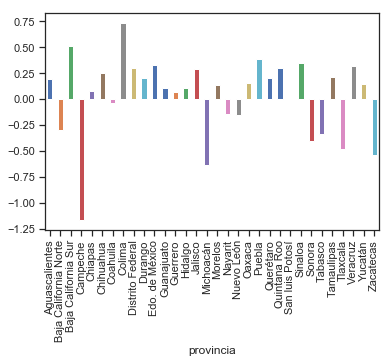

In [97]:
real_casa16['delta'].plot(kind='bar')

In [25]:
#pal_unicas = [x[0].split(' ') for x in desc_unicas.items()]
pal_unicas = []
for x in desc_unicas.items():
    for pal in x[0].split(' '):
        if len(pal) > 0:
            pal_unicas.append(pal)

## Correlación de Google Trends con caracteristicas de venta

In [60]:
sentiment = df.merge(trends,how='inner',on='fecha')
sentiment2 = sentiment[['tipodepropiedad', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'fecha',
       'precio', 'year', 'fecha_mes',
       'precio_constantes', 'Month', 'comprar casa: (Mexico)',
       'vender casa: (Mexico)']]
sentimentCasas = sentiment.loc[(sentiment2.tipodepropiedad=='Casa') & (sentiment2.habitaciones==3)]
sentimentCasas['month'] = sentimentCasas.fecha_mes.dt.month
corrSentimentCasas = sentimentCasas[['antiguedad','garages',\
                                     'metroscubiertos','metrostotales','year','month',\
                                     'precio_constantes','comprar casa: (Mexico)','vender casa: (Mexico)']]

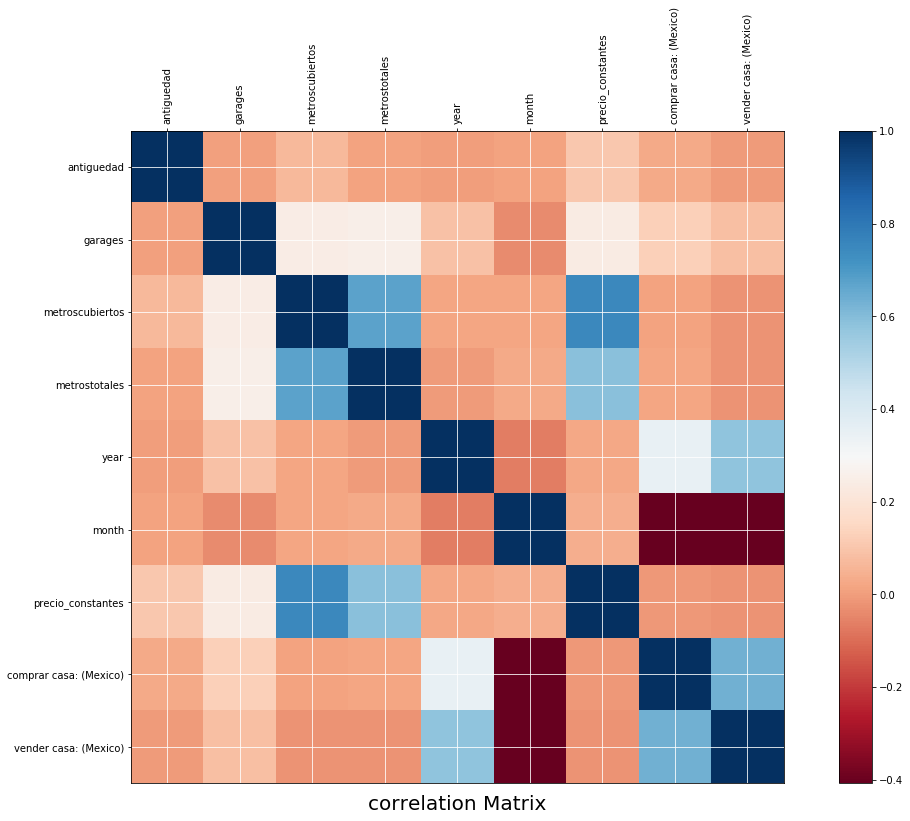

In [39]:
cor = corrSentimentCasas.corr()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))


fig, ax = plt.subplots(figsize=[20,12])

plt.title("correlation Matrix", fontsize = 20, y=-0.05)
image = ax.imshow(cor, cmap = 'RdBu')

plt.xticks(np.arange(len(cor.columns)),cor.columns, rotation = 'vertical')
ax.xaxis.tick_top()
plt.yticks(np.arange(len(cor.columns)),cor.columns, rotation = 'horizontal')
fig.colorbar(image, ax=ax)
plt.rcParams['grid.color'] = "w"
plt.grid()
#plt.savefig('IMG7')
plt.show()


In [ ]:
corrSentimentCasas.head()

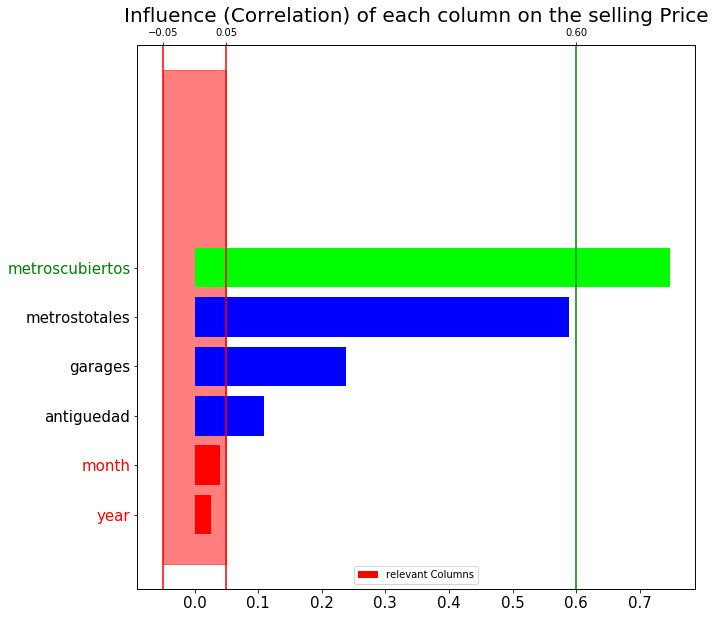

In [28]:
#order the correlations and their associated column
minCorrValue = 0.05
goodCorrValue = 0.6

corrOrdered = list(upper['precio_constantes'].copy().sort_values())
numNan = upper['precio_constantes'].isnull().sum()
colOrdered = [upper.columns[list(upper['precio_constantes']).index(x)] for x in corrOrdered[:-numNan]]

# We have colOrdered, corrOrdered, numNan, lowCorrelatedColumns

lowCorrelatedColumns, highCorrelatedColumns = [], []

#get the high and low correlated columns + color
colorList= ['b']*len(colOrdered)
for x in corrOrdered:
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x<minCorrValue]:
        colorList[corrOrdered.index(x)] = 'r'                    #undecoralated columns are red
        lowCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
    if abs(x) in [x for x in list(upper['precio_constantes'].abs()) if x>goodCorrValue]:
        colorList[corrOrdered.index(x)] = 'lime'                    #undecoralated columns are red
        highCorrelatedColumns.append(colOrdered[corrOrdered.index(x)])
                        
            
plt.figure(figsize=[10,10])
plt.barh(colOrdered,corrOrdered[:-numNan], color=colorList)
plt.title("Influence (Correlation) of each column on the selling Price", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend( ['relevant Columns','good'])
plt.axvline(x= minCorrValue, c='r')
plt.fill_between([-minCorrValue,minCorrValue], [len(upper),len(upper)],[-1,-1], alpha = 0.5, color = 'red')
plt.axvline(x= -minCorrValue, c='r')
plt.axvline(x= goodCorrValue, c='g')
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([-minCorrValue,minCorrValue,goodCorrValue])

#color the yticks
for x in lowCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("red")
for x in highCorrelatedColumns:
        ax.get_yticklabels()[colOrdered.index(x)].set_color("green")

plt.show()
#print("Low correlatedColumns", lowCorrelatedColumns)

In [91]:
dfan = df.drop(columns=['fecha_mes','year','indice'])

[['titulo' nan]
 ['descripcion' nan]
 ['tipodepropiedad' nan]
 ['direccion' nan]
 ['ciudad' nan]
 ['provincia' nan]]


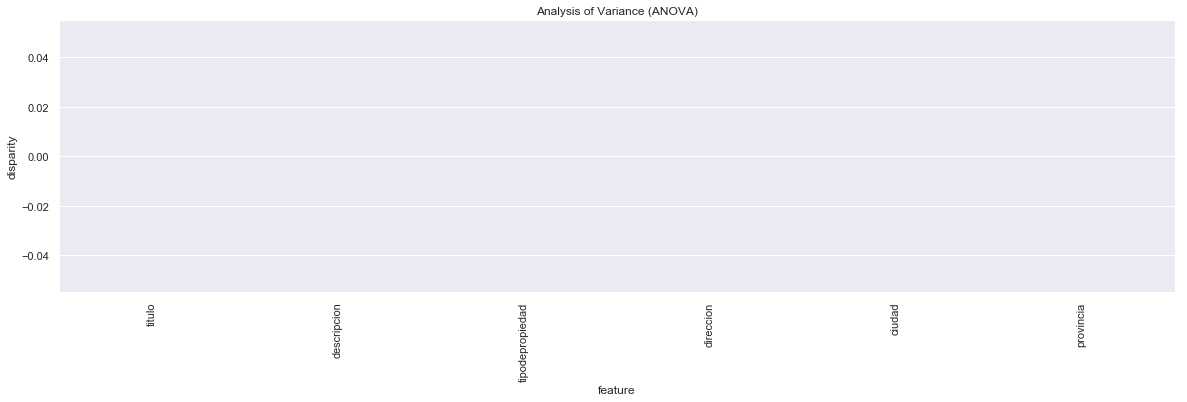

In [92]:
qualitative = dfan.select_dtypes('object').columns
plt.figure(figsize = [20,5])
anova = pd.DataFrame(columns = ['feature','pvalue'])
anova['feature'] = qualitative
for col in qualitative: #for each qualitative column we get the pvalues
    samples = []
    for elt in feat[col].unique():
        samples.append(dfan['precio'][df[col] == elt].values)
    a = stats.f_oneway(*samples)
    anova['pvalue'][anova['feature']==col] = a.pvalue   

#sort and cast
anova = anova.sort_values('pvalue')
anova['pvalue'] = anova['pvalue'].astype('float') 
print(anova.values)

#transform for better visualisation and plot
anova['disparity'] = np.log(1./anova['pvalue'].values)

#anova.plot(kind='bar',x = 'feature',y = 'disparity', cmap = 'rainbow')
sns.barplot(data=anova, x='feature', y='disparity')
x=plt.xticks(rotation=90)
plt.title('Analysis of Variance (ANOVA)')
plt.show()

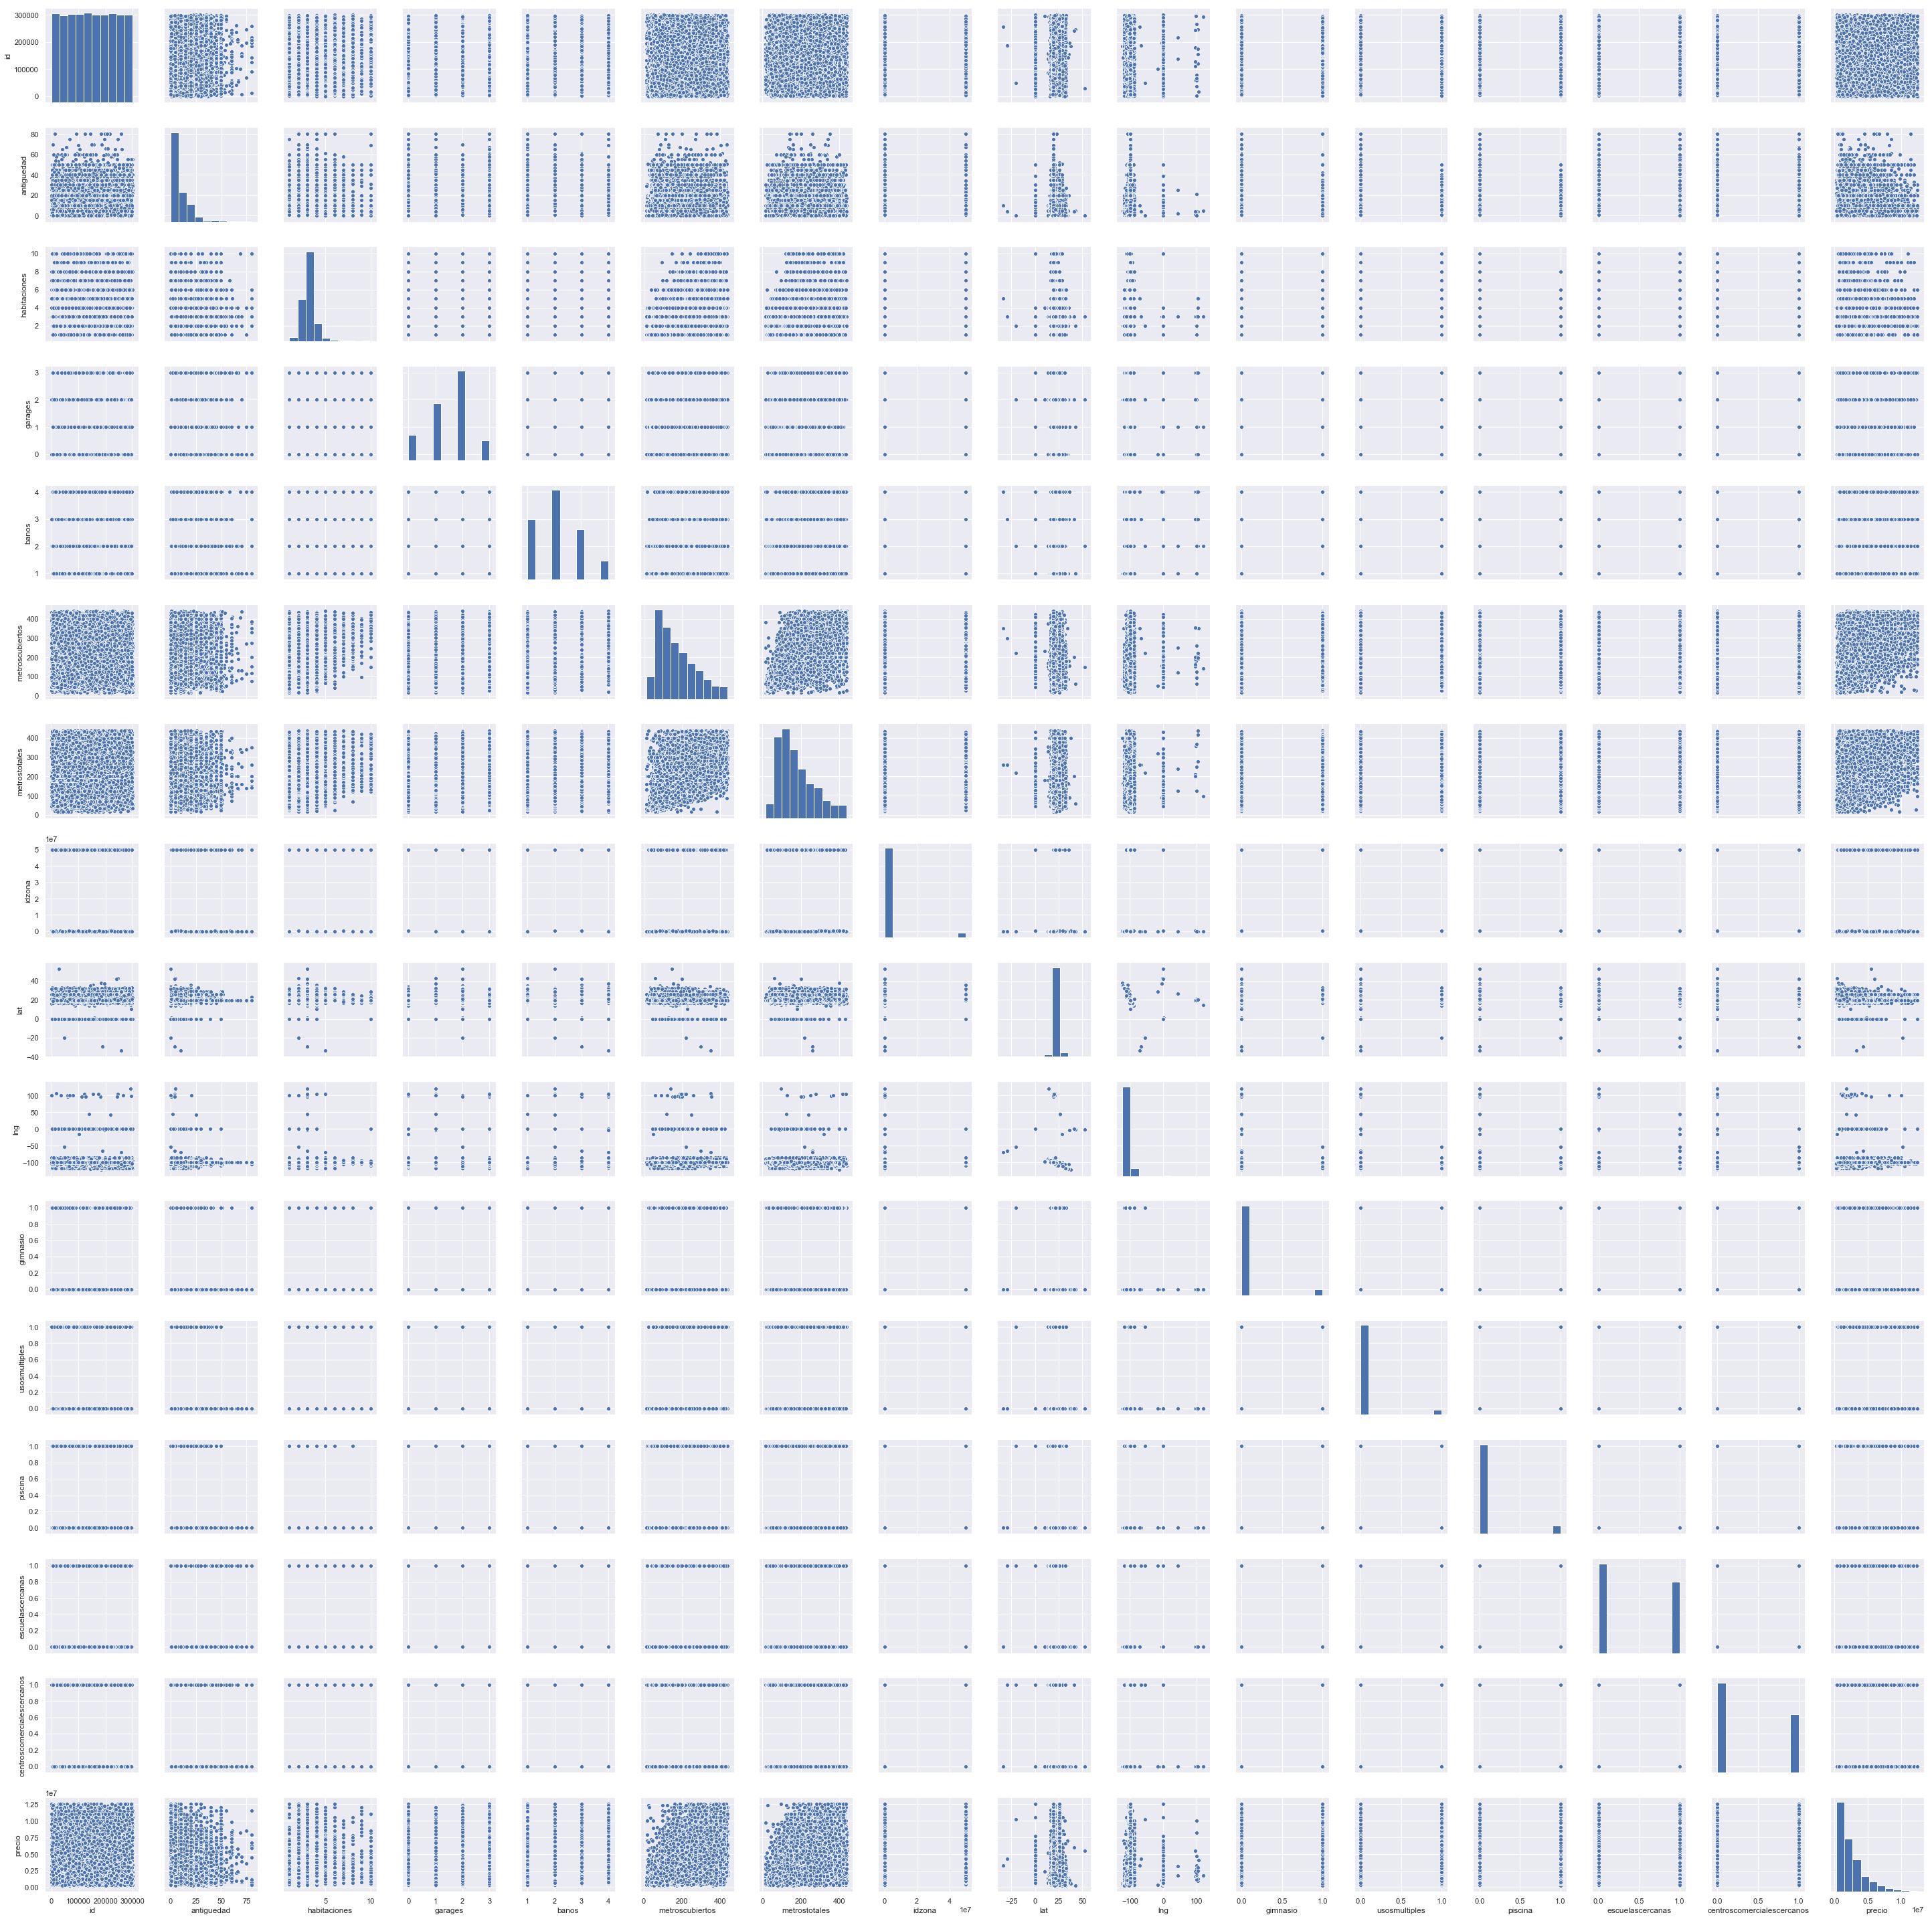

In [71]:
#scatterplot
sns.set()
cols = ['precio','year','metroscubiertos','banos','metrostotales','habitaciones','garages','piscina','antiguedad','gimnasio']
sns.pairplot(feat, height = 2.5)
plt.show()
#plt.savefig('scatter_corr')

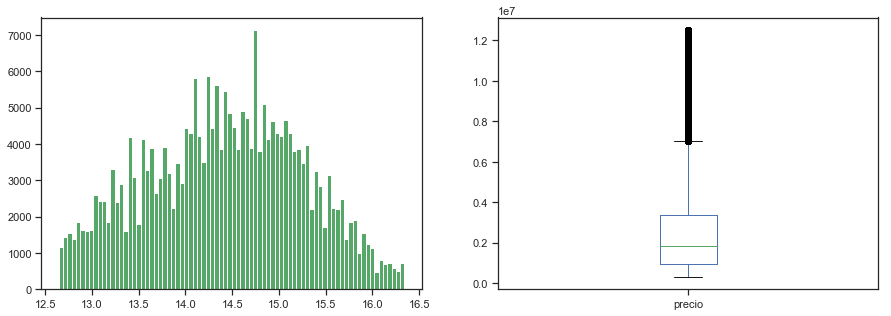

In [32]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].ticklabel_format(style = 'plain')
#df['precio'].hist(bins=80, ax=axes[0], color='r'); 
np.log(df['precio']).hist(bins=80, ax=axes[0], color='g'); 
df['precio'].plot(kind='box', ax=axes[1]);
plt.show()

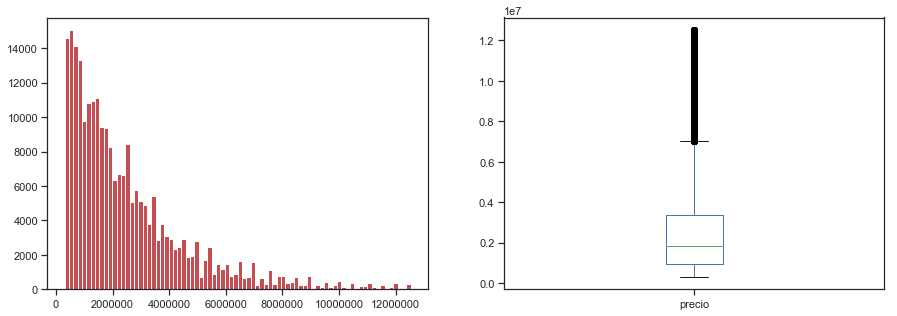

In [33]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].ticklabel_format(style = 'plain')
df['precio'].hist(bins=80, ax=axes[0], color='r'); 
#np.log(df['precio']).hist(bins=80, ax=axes[0], color='g'); 
df['precio'].plot(kind='box', ax=axes[1]);
plt.show()

## Analicemos la Antiguedad

In [30]:
df.groupby('provincia').agg({'antiguedad':'mean'}).sort_values('antiguedad')

,antiguedad
provincia,
Baja California Sur,2.46
Yucatán,3.07
Hidalgo,3.47
Tlaxcala,3.69
Querétaro,3.70
Campeche,3.91
San luis Potosí,3.98
Quintana Roo,4.54
Puebla,4.55


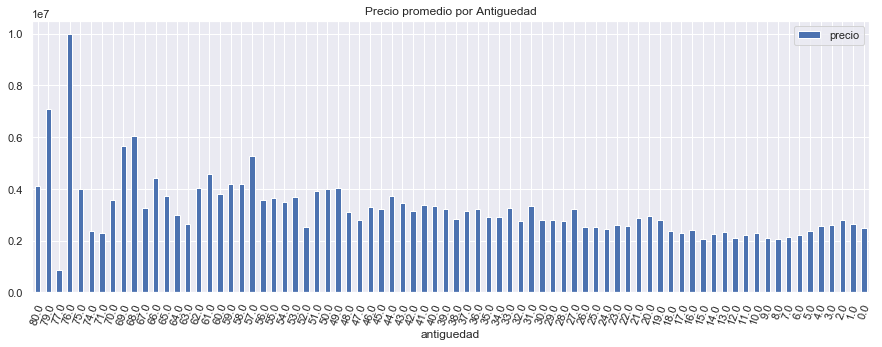

In [77]:
# Precio promedio por tipo de propiedad
df.groupby('antiguedad').agg({'precio': 'mean'})\
    .sort_values('antiguedad', ascending=False)\
    .plot(kind='bar', figsize=(15, 5), rot=70, title="Precio promedio por Antiguedad");

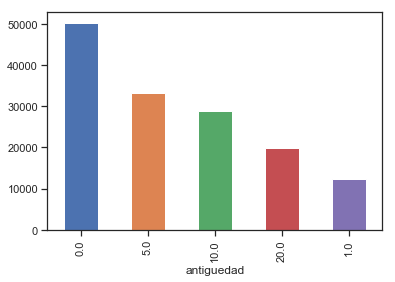

In [36]:
df.groupby(by=['antiguedad']).size().sort_values(ascending=False).nlargest(5).plot(kind='bar')

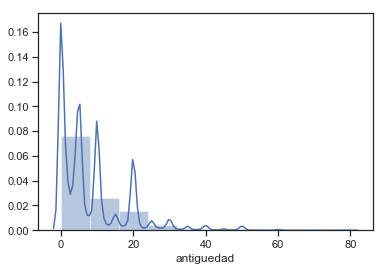

In [37]:
sns.distplot(df['antiguedad'],bins=10)

## Unsorted Analysis

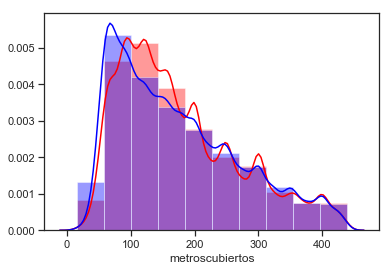

In [38]:
sns.distplot(df['metrostotales'],bins=10,color='red')
sns.distplot(df['metroscubiertos'],bins=10,color ='blue')

In [82]:
df['precio_usd']=df['precio']/19.54

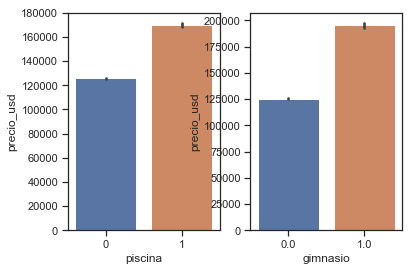

In [41]:
fig, ax =plt.subplots(1,2)
sns.barplot(x=df['piscina'],y=df['precio_usd'],ax=ax[0])
sns.barplot(x=df['gimnasio'],y=df['precio_usd'],ax=ax[1])
fig.show()

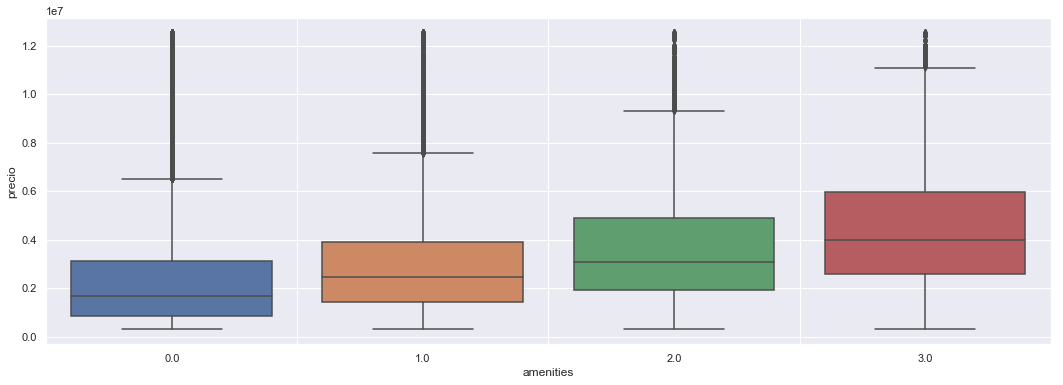

In [80]:
tiposPrincipales = df.tipodepropiedad.value_counts().sort_values(kind="quicksort", ascending=False).to_frame()
df['amenities'] = df.gimnasio + df.usosmultiples + df.piscina #+ df.escuelascercanas + df.centroscomercialescercanos
df['plus']  = df.habitaciones + df.banos + df.garages + df.gimnasio + df.usosmultiples + df.piscina + df.escuelascercanas + df.centroscomercialescercanos

# df[['amenities', 'precio']].plot(x ='amenities', y='precio', kind = '')
dfProps = df[df.tipodepropiedad.isin(tiposPrincipales.head(5).tipodepropiedad.index)]

from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(18,6))
ax1 = sns.boxplot('amenities', "precio", data=dfProps) #, hue='modelLine')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

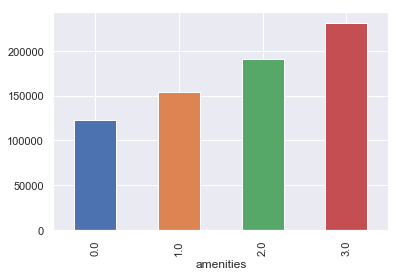

In [84]:
df.groupby('amenities')['precio_usd'].mean().plot(kind='bar')

In [44]:
df['year'] = df['fecha'].dt.year

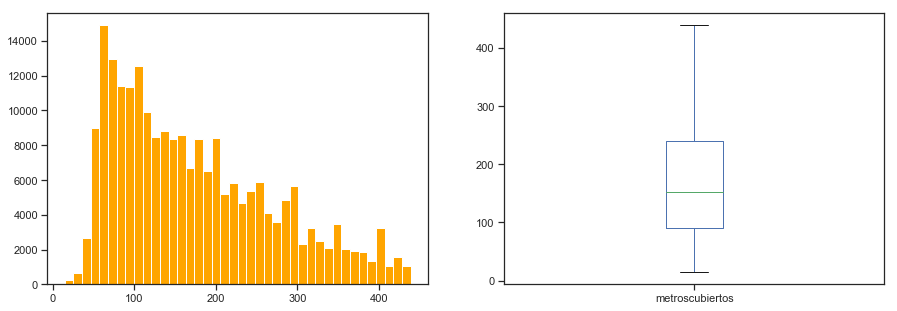

In [45]:
# Distribución de metros cubiertos
_, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.ticklabel_format(style = 'plain')
df['metroscubiertos'].hist(bins=40, ax=axes[0], color='orange');
df['metroscubiertos'].plot(kind='box', ax=axes[1]);